<a href="https://colab.research.google.com/github/smolnaim/A-BMusclehub/blob/main/musclehub_ab_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B Test for MuscleHub
***

## Introduction

Like most businesses, Janet keeps her data in a SQL database. You have already downloaded the data from her database to a csv file, and will load it into a Jupyter Notebook using pandas to conduct A/B testing for the MuscleHub Gym.

Let's get started!

## Import the dataset

Janet of MuscleHub has a SQLite database, which contains several tables that will be helpful to you in this investigation. You have already created a csv file for each table.

Import the four csv files as pandas DataFrames and examine them.

In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [ ]:
# Create and examine the visits DataFrame
visits = pd.read_csv('visits.csv')
visits.head()

fitness_tests = pd.read_csv('fitness_tests.csv')
fitness_tests.head()

applications = pd.read_csv('applications.csv')
applications.head()

purchases = pd.read_csv('purchases.csv')
purchases.head()

,first_name,last_name,email,gender,purchase_date
0,Roy,Abbott,RoyAbbott32@gmail.com,male,2017-08-18
1,Roberta,Acevedo,RA8063@gmail.com,female,2017-09-16
2,Vernon,Acosta,VAcosta1975@gmail.com,male,2017-07-20
3,Darren,Acosta,DAcosta1996@hotmail.com,male,2017-07-27
4,Dawn,Adkins,Dawn.Adkins@gmail.com,female,2017-08-24


## Join all of your data

It would be helpful to have a single DataFrame with all of this data.

Create a DataFrame containing all of this data. Keep in mind that not all visits in **visits.csv** occurred during the A/B test. You’ll only want to pull data where `visit_date` is on or after 7-1-17.


You'll need the following columns:

* `visits.first_name`
* `visits.last_name`
* `visits.gender`
* `visits.email`
* `visits.visit_date`
* `fitness_tests.fitness_test_date`
* `applications.application_date`
* `purchases.purchase_date`

In [ ]:
visits = visits[visits['visit_date'] >= '7-1-17']
visits.shape

df = visits.merge(fitness_tests,on=['first_name', 'last_name', 'email', 'gender'], how='left').merge(
    applications,on=['first_name', 'last_name', 'email', 'gender'], how='left').merge(
    purchases,on=['first_name', 'last_name', 'email', 'gender'], how='left')

df.head()
df.shape

(5004, 8)

## Visualize the Groups

Having compiled the DataFrame we can use to begin our project.

Make at least one visualization that depicts the distribution of potential customers that were given a fitness test and those that were not:
- Create a bar plot of the test group variable's distribution.
- Create a pie cart using `plt.pie()`.

<Axes: xlabel='ab_test_group', ylabel='count'>

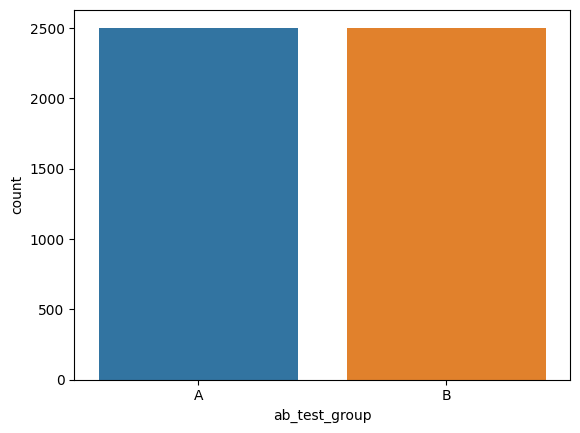

In [ ]:
df['ab_test_group'] = df.fitness_test_date.apply(lambda x:
                                                'A' if pd.notnull(x) else 'B')
df['ab_test_group'].value_counts()
df['ab_test_group'].value_counts(normalize=True)

# Barplot of test group
sns.countplot(x="ab_test_group", data=df)

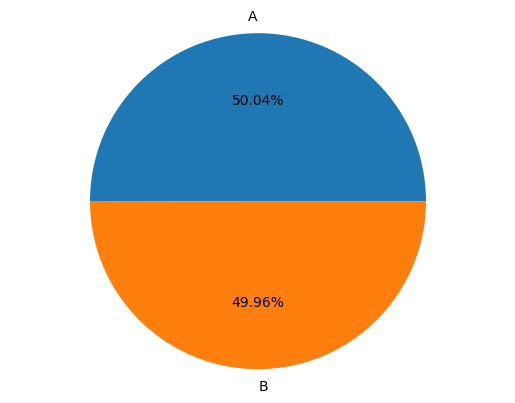

In [ ]:
# Pie chart of test group
plt.pie(df['ab_test_group'].value_counts(), labels=['A', 'B'], autopct='%0.2f%%')
plt.axis('equal')
plt.show()

## Determine the count of applications

Recall that the sign-up process for MuscleHub has several steps:

1. Take a fitness test with a personal trainer (only Group A).
2. Fill out an application for the gym.
3. Send in their payment for their first month's membership.

Determine the percentage of people in each group who complete Step 2, filling out an application.

In [ ]:
# Create variable
df['is_application'] = df.application_date.apply(lambda x: 'Application'
                                                  if pd.notnull(x) else 'No Application')

app_counts = df.groupby(['ab_test_group', 'is_application'])\
               .first_name.count().reset_index()

In [ ]:
# Pivot DataFrame
app_pivot = app_counts.pivot(columns='is_application',
                            index='ab_test_group',
                            values='first_name')\
            .reset_index()

app_pivot

is_application,ab_test_group,Application,No Application
0,A,250,2254
1,B,325,2175


It looks like more people from Group B turned in an application.  Why might that be?

We need to know if this difference is statistically significant.

## Calculate the statistical significance of applications

Having calculated the difference in who turned in an application between groups, determine if this difference is statistically significant.

In [ ]:
# Import hypothesis test module
from scipy.stats import chi2_contingency

# Calculate the p-value
contingency = [[250, 2254], [325, 2175]]
chi2_contingency(contingency)

Chi2ContingencyResult(statistic=10.893961295282612, pvalue=0.0009647827600722304, dof=1, expected_freq=array([[ 287.72981615, 2216.27018385],
       [ 287.27018385, 2212.72981615]]))

## Detemine the count of memberships from applications

Of those who picked up an application, how many purchased a membership?

Determine how many potential customers purchased a membership out of those that picked up an application.

It looks like people who took the fitness test were more likely to purchase a membership if they picked up an application. Why might that be?

In [ ]:
# Create an is_member variable
df['is_member'] = df.purchase_date.apply(lambda x: 'Member' if pd.notnull(x) else 'Not Member')

# Create the just_apps DataFrame
just_apps = df[df.is_application == 'Application']

# Create member_count DataFrame
member_count = just_apps.groupby(['ab_test_group', 'is_member'])\
                 .first_name.count().reset_index()

# Pivot member_count
member_pivot = member_count.pivot(columns='is_member',
                                  index='ab_test_group',
                                  values='first_name')\
                           .reset_index()

# Create the Total variable
member_pivot['Total'] = member_pivot.Member + member_pivot['Not Member']

# Create the Percent Purchase variable
member_pivot['Percent Purchase'] = member_pivot.Member / member_pivot.Total
member_pivot

is_member,ab_test_group,Member,Not Member,Total,Percent Purchase
0,A,200,50,250,0.800000
1,B,250,75,325,0.769231


## Calculate the statistical significance of memberships

Calculate if the difference between the following groups is statistically significant:
- The customers that picked up an application and took a fitness test.
- The customers that did not take a fitness test and picked up an application.

In [ ]:
# Calculate the p-value
contingency = [[200, 50], [250, 75]]
chi2_contingency(contingency)

Chi2ContingencyResult(statistic=0.615869230769231, pvalue=0.43258646051083327, dof=1, expected_freq=array([[195.65217391,  54.34782609],
       [254.34782609,  70.65217391]]))

## Detemine the count of all memberships

Previously, you looked at what percentage of people who picked up applications purchased memberships.

Now, determine what percentage of ALL visitors purchased memberships.

In [ ]:
# Create final_member_count DataFrame
final_member_count = df.groupby(['ab_test_group', 'is_member'])\
                 .first_name.count().reset_index()
# Pivot final_member_count
final_member_pivot = final_member_count.pivot(columns='is_member',
                                  index='ab_test_group',
                                  values='first_name')\
                           .reset_index()

# Create the Total variable
final_member_pivot['Total'] = final_member_pivot.Member + final_member_pivot['Not Member']

# Create the Percent Purchase variable
final_member_pivot['Percent Purchase'] = final_member_pivot.Member / final_member_pivot.Total
final_member_pivot

is_member,ab_test_group,Member,Not Member,Total,Percent Purchase
0,A,200,2304,2504,0.079872
1,B,250,2250,2500,0.100000


## Calculate the statistical significance between groups

Determine if there is a significant difference in memberships between Group A and Group B.

In [ ]:
# Calculate the p-value
contingency = [[200, 2304], [250, 2250]]
chi2_contingency(contingency)

Chi2ContingencyResult(statistic=5.949182292591156, pvalue=0.014724114645783203, dof=1, expected_freq=array([[ 225.17985612, 2278.82014388],
       [ 224.82014388, 2275.17985612]]))

## Visualize the results

Create visualizations for Janet that show the difference between Group A (people who were given the fitness test) and Group B (people who were not given the fitness test) at each state of the process:

- Percent of visitors who apply.
- Percent of applicants who purchase a membership.
- Percent of visitors who purchase a membership.

KeyError: ignored

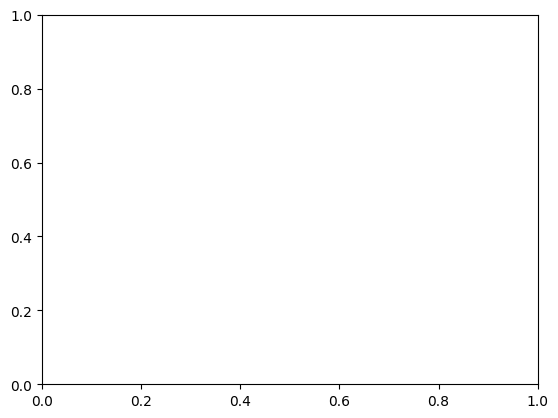

In [ ]:
# Percent of Visitors who Apply
ax = plt.subplot()
plt.bar(range(len(app_pivot)),
       app_pivot['Percent with Application'].values)
ax.set_xticks(range(len(app_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])
plt.show()
# plt.savefig('percent_visitors_apply.png')

In [ ]:
# Percent of Applicants who Purchase
ax = plt.subplot()
plt.bar(range(len(member_pivot)),
       member_pivot['Percent Purchase'].values)
ax.set_xticks(range(len(member_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
ax.set_yticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'])
plt.show()
# plt.savefig('percent_apply_purchase.png')

In [ ]:
# Percent of Visitors who Purchase
ax = plt.subplot()
plt.bar(range(len(final_member_pivot)),
       final_member_pivot['Percent Purchase'].values)
ax.set_xticks(range(len(final_member_pivot)))
ax.set_xticklabels(['Fitness Test', 'No Fitness Test'])
ax.set_yticks([0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels(['0%', '5%', '10%', '15%', '20%'])
plt.show()
# plt.savefig('percent_visitors_purchase.png')

## Congratulations!!

Congratulations, your work has been a valuable contribution for Janet to determine MuscleHub's membership process. Janet asks if you would also help her share your work with a presentation.

## Challenge Assignment

- Develop a presentation that demonstrates your findings to Janet. She has decided that your recommendation will determine if potential customers should take a fitness test as a component of their application. Your presentation should include the following:
    - A title slide
    - A description of what happened in this A/B test
    - A summary of your dataset and any information you think would be helpful background
    - The results of the three hypothesis tests that you ran, including an explanation of the type of test that you used and why it was appropriate
    - A summary of the qualitative data
    - A recommendation for MuscleHub

- Create a [wordcloud](https://pypi.org/project/wordcloud/) visualization that Janet can use to create an ad for the MuscleHub Gym with the data in `interviews.txt`.

In [ ]:
# Import modules
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator # for creating wordclouds
from collections import Counter  # for counting objects
from matplotlib.pyplot import figure # to create a figure in matplotlib

# Open and read the interviews.txt file
interviews = open(r"interviews.txt", encoding='utf8')
txtContent = interviews.read()
print ("The Content of text file is : ", txtContent)

# Print the length of the new string
print('There are {} words in the total interviews.txt file.'.format(len(txtContent)))

# Create a wordcloud object
wordcloud = WordCloud(width=2500, height=1250).generate(txtContent)

# Display the wordcloud with MatplotLib and save figure
figure(num=None, figsize=(20, 16), facecolor='w', edgecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
# plt.savefig('response_data/responses_wordcloud.png')